## Recuit simulé pour le problème du voyageur de commerce

CSI4506 Intelligence Artificielle  
Automne 2020 
Caroline Barrière, Julian Templeton et Justin Charbonneau

Ce devoir vous permettra de mieux comprendre les algorithmes de recherche aléatoire vus en classe, en particulier l'algorithme de *recuit simulé*, qui est une méthode connue qui exemplifie bien la *modification aléatoire*.  Au départ, une solution gloutonne est proposée.  Cette solution est révisée petit à petit pour arriver à une meilleure solution.

Le domaine d'application utilisé ici pour expérimenter avec le *recuit simulé* est le problème du voyageur de commerce (Traveling salesman problem).  C'est un problème classique, dans lequel le but est de visiter toutes les villes d'un graphe interconnecté de villes, et ce, en parcourant la plus petite distance possible.

Ce notebook va dabord explorer la __méthode gloutonne__ puis la __méthode gloutonne aléatoire__ pour enfin aboutir au __recuit simulé__.

***DEVOIR***:  
Parcourir le notebook, en exécutant chaque cellule, une à une.  
Pour chaque **(TO DO)**, effectuer les tâches demandées.  
Quand vous avez terminé, signez (voir cette étape ajoutée à la fin) et soumettez votre notebook.

Ce notebook sera évalué sur 20 points.  
Chaque **(TO DO)** aura un pointage associé.
***

**1. Nous définissons d'abord un petit nombre de villes**

In [ ]:
# let's define 5 cities with a label and a (x,y) coordinate
cities = {'A': (0,0), 'B': (1,1), 'C': (1,0), 'D': (1,-1), 'E': (-1,-1)}

La méthode *showNodes* ci-bas nous permet de visualiser la position des villes.

Les packages **matplotlib** , **networkx** et **numpy** doivent d'abord être installés. 

Pour faire l'installation des packages, ouvrir une invite de commande, et tapez **pip install networkx** ainsi que **pip install numpy** (Si vous avez linux ou un Mac, vous pouvez utiliser **pip3** au lieu de **pip** selon la configuration de votre environnement). Matplotlib devrait déjà être installé mais si ce n'est pas le cas, utilisez la commande **pip install matplotlib** pour l'installer.

Vous pouvez également profiter des commandes magiques et insérer une cellule de code et inscrire **%pip install networkx**.  Une fois les packages installés, vous devrez probablement redémarrer le *kernel*.  Ensuite, vous serez en mesure d'exécuter la cellule ci-bas.

In [27]:
import matplotlib.pyplot as plt
import networkx as nx

# small method to show nodes
# provide defaults for figure size (size), as well as x and y axis
def showNodes(nodeDict, size= (6.5, 4), xLim=[-2,2], yLim=[-2,2]):
    fig = plt.figure(figsize=size)
    axg = fig.add_subplot(111)
    axg.set_xlim(xLim)
    axg.set_ylim(yLim)

    G=nx.Graph()
    for k in nodeDict.keys():
        G.add_node(k, coor=nodeDict.get(k))
    
    pos=nx.get_node_attributes(G,'coor')
    nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.show()

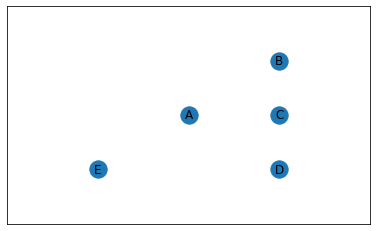

In [28]:
# show the cities on a map
showNodes(cities)

#### 2. Mesurons les distances entre les villes
D'abord, nous définissons une méthode pour calculer la distance entre deux villes spécifiques.  Ensuite nous définissons une méthode pour trouver l'ensemble des distances entre plusieurs paires de noeuds (villes).

In [29]:
import math

def dist(node1, node2):
    """
    Returns the euclidian distance between two nodes
    """
    return round(math.sqrt(math.pow(node1[0] - node2[0], 2) + math.pow(node1[1] - node2[1], 2)), 3)

In [30]:
# Small test to see the distance
dist(cities.get('A'), cities.get('B'))

1.414

In [31]:
def distDict(nodes):
    """Building a dictionary of all pairs or distances"""
    distance = {}
    # go through all pairs of nodes
    for k in nodes.keys():
        for m in nodes.keys():
            distance[k,m] = dist(nodes.get(k), nodes.get(m))
    return distance

In [32]:
# showing the distances between the cities
distances = distDict(cities)
print(distances)
print(distances['A','A'])

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 1.0, ('C', 'E'): 2.236, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 1.0, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0}
0.0


Ajoutons aussi une méthode pour trouver la ville la plus proche d'une autre ville.  Cette méthode sera utile plus tard.

In [33]:
def closestNode(node1_label, otherNodes_Labels, distanceDict):
    """
    Find the min distance from node1 to all other nodes.
    It receives the node1 label, the labels of other nodes to test, and the precalculated distances between all nodes
    """
    # tricky syntax... it creates tuples where the distance is the first element of the tuple
    # and the position in the array is the second element of the tuple
    minDist = min( (distanceDict[node1_label,k], k) for k in otherNodes_Labels)
    # get the second element of the tuple which is the index found
    foundNode = minDist[1]
    return foundNode

In [34]:
# Testing the closest node
closestNode('B', ['C', 'D'], distances)

'C'

#### 3. Solution gloutonne d'abord
Avant de pouvoir utiliser le *recuit simulé*, il faut une première solution sous-optimale.  Nous utilisons un algorithme glouton pour générer cette solution. D'abord, le choix du noeud initiale sera aléatoire, puis par après l'algorithme choisira toujours le noeud le plus près. 

In [35]:
# greedy solution
import random

def greedy_solution(nodes):
    # distance matrix
    allDist = distDict(nodes)
    # pick a first node at random among the set of keys (node names)
    cur_node = random.choice(list(nodes.keys()))
    # add that node to solution
    solution = [cur_node]
    # build a free list of nodes (not yet used) containing all nodes except the one just chosen 
    free_list = list(nodes.keys())
    free_list.remove(cur_node)
    
    # while there are still nodes to be attached
    while free_list:
        # find the closestNode
        found_node = closestNode(cur_node, free_list, allDist)
        cur_node = found_node
        free_list.remove(cur_node)
        solution.append(cur_node)

    return solution

In [90]:
# Test obtaining a greedy solution
gs = greedy_solution(cities)
print(gs)

['E', 'A', 'C', 'B', 'D']


#### 4. Visualisation d'un chemin dans le graphe  
Nous modifions légèrement la méthode *showNodes* vue précédemment pour devenir *showPath* et montrer un chemin dans un graphe dirigé. 

In [91]:
def showPath(path, nodeDict, size= (6.5, 4), xLim=[-2,2], yLim=[-2,2]):
    """
    Small method to show a path
    It receives an ordered list of nodes e.g. ['B','C','A', 'D', 'E'] and a dictionary of all the nodes and their positions
    """
    fig = plt.figure(figsize=size)
    axg = fig.add_subplot(111)
    axg.set_xlim(xLim)
    axg.set_ylim(yLim)

    G=nx.DiGraph()
    for k in path:
        G.add_node(k, pos=nodeDict.get(k))
        
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i + 1]
        G.add_edge(x,y)
        
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, with_labels = True, edge_color = 'b', arrows=True)   
    # nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.show()

**(TO DO) Q1 - 2 points**  
1. Sélectionner un seed (numéro entier) à spécifier ci-bas pour rendre votre code reproductible.
2. Exécuter la cellule pour initialiser le générateur de nombres pseudo-aléatoires avec un numéro d'initialisation (**une fois seulement**)
3. Exécuter les test en-dessous de la déclaration du générateur de nombre plusieurs fois (manuellement exécuter la cellule) jusqu'à l'optention de deux solutions identiques. Enregistrer le nombre de fois que vous avez exécuter la cellule dans la section réponse ainsi que les deux chemins pour les deux solutions dans la section réponse.
4. Exécuter les test en-dessous de la déclaration du générateur de nombre plusieurs fois encore jusqu'à l'obtention de résultats différents pour les deux solutions. Enregistrer le nombre de fois que vous avez exécuter la cellule ainsi que les deux différents chemins pour les deux solutions dans la section réponse.

**(Présentez vos réponses dans ce Markdown)**  
Nb d'exécutions pour générer deux solutions identiques gs1 et gs2 :  8
Chemins des 2 solutions identiques gs1 et gs2 : B C A D E

Nb d'exécutions pour générer deux solutions différentes gs1 et gs2 :  1
Chemins des 2 solutions différentes gs1 et gs2 : B C A D E , E A C B D

Initialiser le générateur de nombres 

In [38]:
# (TO DO) for reproducibility
random.seed(3) # Enter any integer in the parenthesis to set the seed

Un test pour visualiser 2 solutions gloutonnes. Regardez la sortie de texte du chemin pour voir si le graphique tracé contient des arêtes qui passent par un nœud.

['E', 'A', 'C', 'B', 'D']


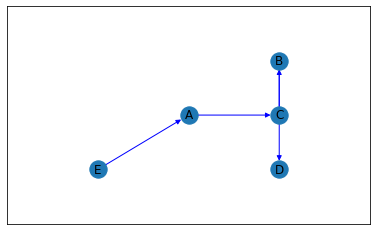

['D', 'C', 'A', 'B', 'E']


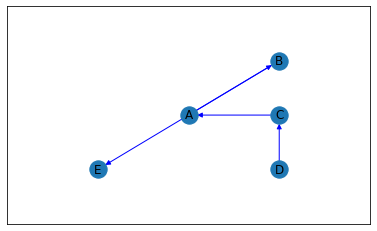

In [106]:
# Testing to output the path chosen by the greedy solution
gs1 = greedy_solution(cities)
print(gs1)
showPath(gs1, cities)
gs2 = greedy_solution(cities)
print(gs2)
showPath(gs2, cities)

**(TO DO) Q2 - 2 points**  
Compléter la méthode ci-bas pour trouver la longueur total d'un chemin. 

In [107]:
# (TO DO) totalDistance, which receives a path (list of node labels) and the dictionary of distances
def totalDist(path, distanceDict):
    total = 0
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i+1]
        total += distanceDict[x,y]
    return round(total,3)

In [110]:
# Test the total distance method
print(totalDist(gs1, distances))
print(totalDist(gs2, distances))

5.414
6.242


**(TO DO) Q3 - 4 points**  
Ajouter 2 nouvelles villes (positionner les villes où vous voulez dans le graphe prédéfini de -2 à 2).  Donc, refaire la séquence d'étapes ci-haut (1) définir un graphe, (2) visualiser les positions des villes (3) contruire le dictionnaire des distances (4) trouver deux solutions gloutonnes (5) montrer les chemins pour ces solutions. 

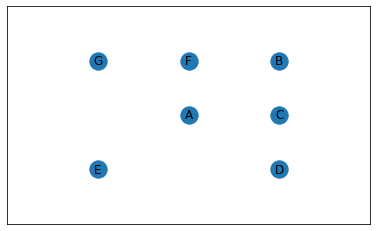

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('A', 'F'): 1.0, ('A', 'G'): 1.414, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('B', 'F'): 1.0, ('B', 'G'): 2.0, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 1.0, ('C', 'E'): 2.236, ('C', 'F'): 1.414, ('C', 'G'): 2.236, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 1.0, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('D', 'F'): 2.236, ('D', 'G'): 2.828, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0, ('E', 'F'): 2.236, ('E', 'G'): 2.0, ('F', 'A'): 1.0, ('F', 'B'): 1.0, ('F', 'C'): 1.414, ('F', 'D'): 2.236, ('F', 'E'): 2.236, ('F', 'F'): 0.0, ('F', 'G'): 1.0, ('G', 'A'): 1.414, ('G', 'B'): 2.0, ('G', 'C'): 2.236, ('G', 'D'): 2.828, ('G', 'E'): 2.0, ('G', 'F'): 1.0, ('G', 'G'): 0.0}


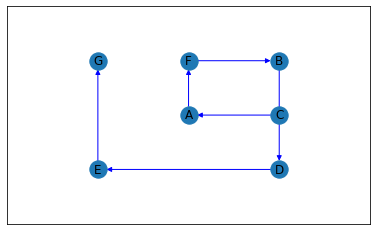

['C', 'A', 'F', 'B', 'D', 'E', 'G']
Total distance for gs3: 9.0


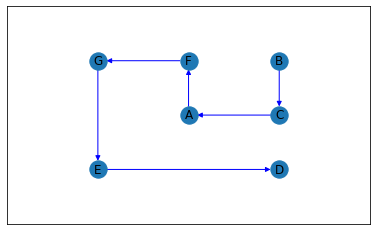

['B', 'C', 'A', 'F', 'G', 'E', 'D']
Total distance for gs4: 8.0


In [111]:
# (1) Defining a larger set of cities  (add two more)
moreCities = {'A': (0,0), 'B': (1,1), 'C': (1,0), 'D': (1,-1), 'E': (-1,-1), 'F': (0, 1) , 'G': (-1, 1)}
# (2) Show the points
showNodes(moreCities)

# (3) Build the distance dictionary
moreDistances = distDict(moreCities)
print(moreDistances)
# (4) Find two unique greedy solutions 
gs3 = greedy_solution(moreCities)
gs4 = greedy_solution(moreCities)

# (5) Show the two unique paths found above along with their total distances
showPath(gs3, moreCities)
print(gs3)
print("Total distance for gs3: " + str(totalDist(gs3, moreDistances)))
showPath(gs4, moreCities)
print(gs4)
print("Total distance for gs4: " + str(totalDist(gs4, moreDistances)))

**5. Gloutonne Aléatoire - Setup**

Avant de créer notre solution gloutonne aléatoire, nous définissons une fonction qui s'appelle kClosestNodes qui retournera les k noeuds les plus près du noeud spécifié.

In [43]:
# find the min distance from node1 to all other nodes.
# it receives the node1 label, the labels of other nodes to test,
# the precalculated distances between all nodes, and k for how many to return
# The function then outputs a list of the k-closest nodes, where the
# first is the closest and the kth is the kth-closest
def kClosestNodes(node1_label, otherNodes_Labels, distanceDict, k):
    kClosest = []
    # Create a sorted distance list based on the values from the distance dictionary
    # This has the form [((node_1, node_2),value_1), ..., ((node_n, node_n), value_n)]
    sortedDistances = sorted(distanceDict.items(), key=lambda keyPair: keyPair[1])
    # Iterate through the sorted distance list to find our k min distances
    # from node1_label
    for key, value in sortedDistances:
        if (k > 0 and key[0] == node1_label and key[1] in otherNodes_Labels):
            k -= 1
            kClosest.append(key[1])
    return kClosest

In [112]:
# Example usage
# View the distance dictionary to verify correctness when finding the closest nodes
# to node B in cities
print(distances)
# Find the two closest nodes to the node B in cities (using its distance dictionary)
kClosestNodes('B', ['A', 'C', 'D', 'E'], distances, 2)

{('A', 'A'): 0.0, ('A', 'B'): 1.414, ('A', 'C'): 1.0, ('A', 'D'): 1.414, ('A', 'E'): 1.414, ('A', 'F'): 1.0, ('A', 'G'): 1.414, ('B', 'A'): 1.414, ('B', 'B'): 0.0, ('B', 'C'): 1.0, ('B', 'D'): 2.0, ('B', 'E'): 2.828, ('B', 'F'): 1.0, ('B', 'G'): 2.0, ('C', 'A'): 1.0, ('C', 'B'): 1.0, ('C', 'C'): 0.0, ('C', 'D'): 1.0, ('C', 'E'): 2.236, ('C', 'F'): 1.414, ('C', 'G'): 2.236, ('D', 'A'): 1.414, ('D', 'B'): 2.0, ('D', 'C'): 1.0, ('D', 'D'): 0.0, ('D', 'E'): 2.0, ('D', 'F'): 2.236, ('D', 'G'): 2.828, ('E', 'A'): 1.414, ('E', 'B'): 2.828, ('E', 'C'): 2.236, ('E', 'D'): 2.0, ('E', 'E'): 0.0, ('E', 'F'): 2.236, ('E', 'G'): 2.0, ('F', 'A'): 1.0, ('F', 'B'): 1.0, ('F', 'C'): 1.414, ('F', 'D'): 2.236, ('F', 'E'): 2.236, ('F', 'F'): 0.0, ('F', 'G'): 1.0, ('G', 'A'): 1.414, ('G', 'B'): 2.0, ('G', 'C'): 2.236, ('G', 'D'): 2.828, ('G', 'E'): 2.0, ('G', 'F'): 1.0, ('G', 'G'): 0.0}


['C', 'A']

**6. Gloutonne Aléatoire**

Maintenant vous allez trouver une autre solution sous-optimale. Cette deuxième solution sera la méthode gloutonne aléatoire.

**(TO DO) Q4 - 5 points**  

La méthode gloutonne aléatoire va dabord sélectionner un noeud initial aléatoire. Ensuite, l'algorithme va choisir aléatoirement un noeud parmis k noeuds disponibles en fonction d'une distribution de probabilités (au lieu du noeud le plus près).

Par exemple, si vous observez les 5 noeuds voisins, vous allez choisir un noeud aléatoirement mais chacun des 5 noeuds aura une probabilité plus ou moins grande d'être sélectionné en fonction de sa distance.

Cette distribution de probabilité est définie avec la fonction *normalize* ci-bas. Les k noeuds les plus près seront retournés par la fonction *kClosestNodes* ci-haut. Vous devez appeler ces deux fonctions dans votre solution puis suivre les instructions défini par les commentaires.

Après avoir terminé, ajouter un autre test aux tests ci-bas avec des différentes valeurs de k.

In [121]:
import random
import numpy as np

# DO NOT EDIT THIS FUNCTION #
def normalize(nodeFrom, nodesTo, distDict):
    """
    nodeFrom is the node we start at, nodesTo is a list of nodes
    that nodeFrom can go to, and distDict is the dictionary of all
    combinations of distances. This provides the probability distribution to be used by
    randomized_greedy_solution
    """
    distances = []
    # Here we normalize by 1/distance^2 
    for nodeTo in nodesTo:
        distances.append(1 / distDict[nodeFrom, nodeTo] ** 2)
    sumOfDistances = sum(distances)
    normalizedDistances = [dist / sumOfDistances for dist in distances]
    return normalizedDistances
    
# TO DO #
def randomized_greedy_solution(nodes, k):
    """
    k represents the number of closest nodes to be returned from the
    function kClosestNodes
    """
    # distance matrix
    allDist = distDict(nodes)
    # pick a first node at random among the set of keys (node names)
    cur_node = random.choice(list(nodes.keys()))
    # add that node to solution
    solution = [cur_node]
    # build a free list of nodes (not yet used) containing all nodes except the one just chosen 
    free_list = list(nodes.keys())
    free_list.remove(cur_node)
    
    # while there are still nodes to be attached
    while free_list:
        
        # TO DO START: Complete the algorithm by performing what the comments ask
        
        # Get the closest nodes
        closest_nodes = kClosestNodes(cur_node,free_list, allDist, k)
        # Find the normalized distances
        normalized_distances = normalize(cur_node, closest_nodes, allDist)
        # Select a random closest node based on the probabilities found by the normalized distances
       
        # You will use the function np.random.choice(options, list_of_probabilities_for_options)
        # For more information on np.random.choice check out the official documentation:
        #      https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html#numpy.random.choice
        # ...
        # Print out the probabilities for each closest node choice (just output both lists saying what they are)
        print('The {} closest nodes are {}' .format(k , closest_nodes))
        print('The normalized distances are {}'.format(normalized_distances))
       
        found_node = np.random.choice(closest_nodes , p = normalized_distances)
        # Print out the closest node selected by the probability distribution with it's probability of being selected       
        print('The closest node is {} with a probability of {}'.format(found_node, normalized_distances[closest_nodes.index(found_node)]))        
   
        
        
    
        # TO DO END
        
        # Same as in the Greedy approach
        cur_node = found_node
        free_list.remove(cur_node)
        solution.append(cur_node)

    return solution



Greedy Test
['B', 'C', 'A', 'F', 'G', 'E', 'D']
8.0


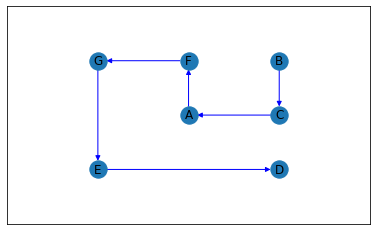

Randomized Greedy Test
The 1 closest nodes are ['A']
The normalized distances are [1.0]
The closest node is A with a probability of 1.0
The 1 closest nodes are ['F']
The normalized distances are [1.0]
The closest node is F with a probability of 1.0
The 1 closest nodes are ['B']
The normalized distances are [1.0]
The closest node is B with a probability of 1.0
The 1 closest nodes are ['D']
The normalized distances are [1.0]
The closest node is D with a probability of 1.0
The 1 closest nodes are ['E']
The normalized distances are [1.0]
The closest node is E with a probability of 1.0
The 1 closest nodes are ['G']
The normalized distances are [1.0]
The closest node is G with a probability of 1.0
['C', 'A', 'F', 'B', 'D', 'E', 'G']
9.0


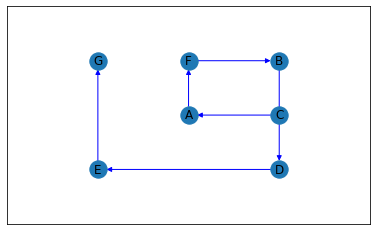

Randomized Greedy Test
The 2 closest nodes are ['A', 'B']
The normalized distances are [0.5, 0.5]
The closest node is B with a probability of 0.5
The 2 closest nodes are ['F', 'A']
The normalized distances are [0.6665995420411309, 0.3334004579588691]
The closest node is A with a probability of 0.3334004579588691
The 2 closest nodes are ['F', 'D']
The normalized distances are [0.6665995420411309, 0.3334004579588691]
The closest node is F with a probability of 0.6665995420411309
The 2 closest nodes are ['G', 'D']
The normalized distances are [0.8333248884610154, 0.1666751115389846]
The closest node is G with a probability of 0.8333248884610154
The 2 closest nodes are ['E', 'D']
The normalized distances are [0.6665995420411309, 0.3334004579588691]
The closest node is E with a probability of 0.6665995420411309
The 2 closest nodes are ['D']
The normalized distances are [1.0]
The closest node is D with a probability of 1.0
['C', 'B', 'A', 'F', 'G', 'E', 'D']
8.414


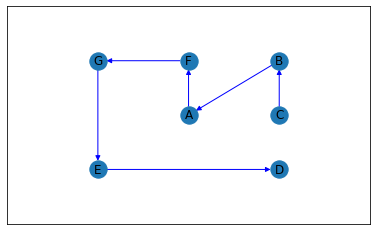

Randomized Greedy Test
The 5 closest nodes are ['C', 'F', 'A', 'D', 'G']
The normalized distances are [0.33331655133208526, 0.33331655133208526, 0.16670862166978692, 0.08332913783302132, 0.08332913783302132]
The closest node is C with a probability of 0.33331655133208526
The 5 closest nodes are ['A', 'D', 'F', 'E', 'G']
The normalized distances are [0.3448067352567815, 0.3448067352567815, 0.17245544917404135, 0.0689655401561978, 0.0689655401561978]
The closest node is F with a probability of 0.17245544917404135
The 5 closest nodes are ['A', 'G', 'D', 'E']
The normalized distances are [0.4166624442305077, 0.4166624442305077, 0.0833375557694923, 0.0833375557694923]
The closest node is G with a probability of 0.4166624442305077
The 5 closest nodes are ['A', 'E', 'D']
The normalized distances are [0.5714778818058016, 0.28565264774274807, 0.1428694704514504]
The closest node is E with a probability of 0.28565264774274807
The 5 closest nodes are ['A', 'D']
The normalized distances are [0.666

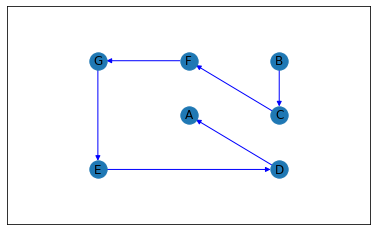

In [118]:
# Testing to output the path chosen by the randomized greedy solution with various k's to the greedy solution
# Run a few times to see how the results differ with the non-deterministic Randomized Greedy solution
# Note that if they start with the same node and k=1 that the results of both will be the same
print("Greedy Test")
gr = greedy_solution(moreCities)
print(gr)
print(totalDist(gr, moreDistances))
showPath(gr, moreCities)
print("Randomized Greedy Test")
rgs1 = randomized_greedy_solution(moreCities, 1)
print(rgs1)
print(totalDist(rgs1, moreDistances))
showPath(rgs1, moreCities)
print("Randomized Greedy Test")
rgs2 = randomized_greedy_solution(moreCities, 2)
print(rgs2)
print(totalDist(rgs2, moreDistances))
showPath(rgs2, moreCities)

# TO DO: Add one more test randomized_greedy_solution with a different k
# ...
print("Randomized Greedy Test")
rgs3 = randomized_greedy_solution(moreCities, 5)
print(rgs3)
print(totalDist(rgs3, moreDistances))
showPath(rgs3, moreCities)


**7. Definissons le processus du recuit simulé**  
La classe ci-bas définit le processus du recuit simulé.  Cette classe est une adaptation de la classe *anneal.py* qui se trouve dans le code python du github https://github.com/chncyhn/simulated-annealing-tsp. Vous n'avez pas à modifier cette classe, mais tenter de la comprendre pour assimiler l'algorithme du recuit simulé. 

In [119]:
# class to perform a simulated annealing
# must start with a set of nodes, all other parameters have defaults
class SimAnneal(object):
    def __init__(self, nodes, randomizedGreedy, k=4, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        # set of nodes
        self.nodes = nodes
        # number of nodes
        self.N = len(nodes)
        # set the temperature T to sqrt(N) if not specified
        self.T = math.sqrt(self.N) if T == -1 else T
        # set alpha (rate at which the temperature is decreased)
        self.alpha = 0.995 if alpha == -1 else alpha
        # set stopping temprature
        self.stopping_temperature = 0.00000001 if stopping_T == -1 else stopping_T
        # set stopping iteration
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        # start at iteration 1
        self.iteration = 1

        # calculate the distances
        self.allDist = distDict(nodes)
        
        # start with greedy solution if randomizedGreedy is false,
        #  start with the randomized greedy solution if randomizedGreedy is true
        if (randomizedGreedy):
            self.cur_solution = randomized_greedy_solution(nodes, k)
            self.improvementMessage = 'Improvement over randomized greedy heuristic: '
        else:
            self.cur_solution = greedy_solution(nodes)
            self.improvementMessage = 'Improvement over greedy heuristic: '
        
        # so far, the best solution is the one we have
        self.best_solution = list(self.cur_solution)

        # calculate fitness of the current solution
        self.cur_fitness = self.fitness(self.cur_solution)
        # initial fitness for initial solution
        self.initial_fitness = self.cur_fitness
        # best fitness so far
        self.best_fitness = self.cur_fitness
        # build the fitness list as we explore solutions
        self.fitness_list = [self.cur_fitness]


    def fitness(self, sol):
        """ Objective value of a solution """
        return totalDist(sol, self.allDist)

    # acceptance propability
    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current
        Depends on the current temperature and difference between candidate and current
        """
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current
        Accept with probabilty p_accept(..) if candidate is worse
        """
        candidate_fitness = self.fitness(candidate)
        # test if fitness is smaller then the current one
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.cur_solution = candidate
            # test if fitness is better than best so far, keep it as best if so
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.best_solution = candidate

        # if solution is worst than the current one, there is still a possibility to pursue it
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness = candidate_fitness
                self.cur_solution = candidate

    def anneal(self):
        """
        Execute simulated annealing algorithm
        """
        # go through the temperature schedule
        print(self.T)
        print(self.stopping_temperature)
        while (self.T >= self.stopping_temperature) and (self.iteration < self.stopping_iter):
            # explore current solution
            candidate = list(self.cur_solution)
            # modify the solution to switch two cities
            # first chosen city between [2,N-1] - not changing the first city
            l = random.randint(2, self.N - 1)
            # second city between [0,N-1] Not sure why ??
            i = random.randint(0, self.N - l)
            # the chosen nodes are switch
            candidate[i:(i + l)] = reversed(candidate[i:(i + l)])
            # perform acceptance test 
            self.accept(candidate)
            # multiply the temperature by alpha (this will reduce it)
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list (to be able to display)
            self.fitness_list.append(self.cur_fitness)

        print('Best fitness obtained: ', self.best_fitness)
        print(self.improvementMessage,
              round((self.initial_fitness - self.best_fitness) / (self.initial_fitness), 4))

        return self.best_solution
    
    def plot_learning(self):
        """
        Plot the fitness through iterations
        """
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel('Fitness')
        plt.xlabel('Iteration')
        plt.show()


#### 8. Refinement d'une solution gloutonne avec recuit simulé

**(TO DO) Q5 - 5 points**  
Ajoutez des commentaires au code ci-bas pour expliquer ce qui se passe.  Aussi exécuter le code quelques fois.  Cela vous montrera qu'il peut y avoir parfois un coût total plus bas en appliquant le recuit simulé.

Solution ['B', 'C', 'A', 'F', 'G', 'E', 'D'] takes a total of 8.0


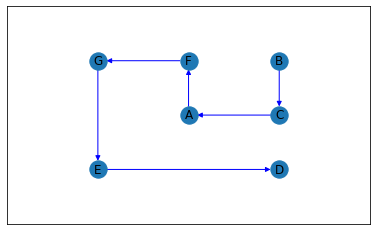

2.6457513110645907
1e-08
Best fitness obtained:  6.828
Improvement over greedy heuristic:  0.1465


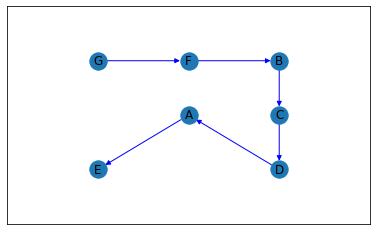

The 4 closest nodes are ['C', 'F', 'B', 'D']
The normalized distances are [0.3332997710205655, 0.3332997710205655, 0.16670022897943457, 0.16670022897943457]
The closest node is F with a probability of 0.3332997710205655
The 4 closest nodes are ['B', 'G', 'C', 'D']
The normalized distances are [0.3703479840205153, 0.3703479840205153, 0.18522993144955543, 0.07407410050941401]
The closest node is G with a probability of 0.3703479840205153
The 4 closest nodes are ['B', 'E', 'C', 'D']
The normalized distances are [0.3030119672644163, 0.3030119672644163, 0.24242431320977617, 0.15155175226139114]
The closest node is D with a probability of 0.15155175226139114
The 4 closest nodes are ['C', 'B', 'E']
The normalized distances are [0.6666666666666666, 0.16666666666666666, 0.16666666666666666]
The closest node is C with a probability of 0.6666666666666666
The 4 closest nodes are ['B', 'E']
The normalized distances are [0.8333248884610154, 0.1666751115389846]
The closest node is B with a probabilit

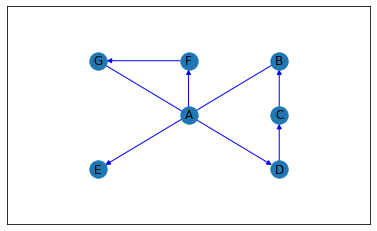

The 4 closest nodes are ['C', 'F', 'B', 'D']
The normalized distances are [0.3332997710205655, 0.3332997710205655, 0.16670022897943457, 0.16670022897943457]
The closest node is C with a probability of 0.3332997710205655
The 4 closest nodes are ['B', 'D', 'F', 'E']
The normalized distances are [0.3703479840205153, 0.3703479840205153, 0.18522993144955543, 0.07407410050941401]
The closest node is B with a probability of 0.3703479840205153
The 4 closest nodes are ['F', 'D', 'G', 'E']
The normalized distances are [0.6153703155402707, 0.15384257888506767, 0.15384257888506767, 0.0769445266895941]
The closest node is F with a probability of 0.6153703155402707
The 4 closest nodes are ['G', 'D', 'E']
The normalized distances are [0.7142733055835567, 0.14286334720822158, 0.14286334720822158]
The closest node is D with a probability of 0.14286334720822158
The 4 closest nodes are ['E', 'G']
The normalized distances are [0.6665995420411309, 0.3334004579588691]
The closest node is E with a probabilit

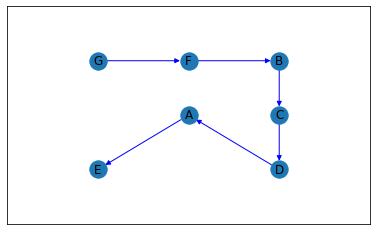

In [123]:
# Finds an initial solution with the greedy_solution algorithm
firstSol = greedy_solution(moreCities)
#Find the distance between every pair of nodes in moreCities
distances = distDict(moreCities)
print('Solution {} takes a total of {}'.format(firstSol,totalDist(firstSol, distances)))
#prints the path found by the solution
showPath(firstSol, moreCities)

#This time, we try to find a better solution with simulated annealing. The False argument means that the 
# initial solution is found with the greedy_solution algorithm (not with the randomized_greedy_solution)
sa = SimAnneal(moreCities, False)
#The anneal method finds the solution by iterating at most 100 000 times while the temperature is above 0.00000001.
#The initial temperature = sqrt(7) and it is decreased by a factor of 0.05 at each iteration

betterSol = sa.anneal()
#prints the solution found by simulated annealing
showPath(betterSol, moreCities)

# Finds a solution by using the randomized_greedy_solution algorithm by comparing each node with the four closest nodes
secondSol = randomized_greedy_solution(moreCities, 4)
#prints the solution found
print('Solution {} takes a total of {}'.format(secondSol,totalDist(secondSol, distances)))
showPath(secondSol, moreCities)

# Finda a better solution with simulated annealing.
# The initial solution is found with the randomized_greedy_solution algorithm by compaaring each node with 
# the four closest nodes
sa2 = SimAnneal(moreCities, True, 4)
betterSol2 = sa2.anneal()
showPath(betterSol2, moreCities)

**9. Test à plus grande échelle**  
Le fichier *coord.txt* (que vous trouverez aussi sur Brightspace dans la section des Jupyter Notebooks), contient un ensemble de coordonnées. Ce fichier de données est aussi tiré du github https://github.com/chncyhn/simulated-annealing-tsp.  Voici le début du fichier.

1 0 0  
2 3 5  
3 2.5 9  
4 48 16  
5 48 17  
6 69 16  
...  

Nous utiliserons le chiffre de la première colonne comme étiquette de la ville (e.g. ville 0, ville 1, ...) et les deux autres colonnes comme les coordonnées.

Assurez-vous de mettre le fichier *coord.txt* dans le même répertoire que votre notebook (ou sinon changer le chemin d'accès dans le code ci-bas).

In [86]:
# reading the coordinates
manyCities = {}
with open('coord.txt','r') as f:
    i = 0
    for line in f.readlines():
        line = [float(x.replace('\n','')) for x in line.split(' ')]
        label = str(int(line[0]))
        manyCities[label] = (line[1], line[2])
        i += 1

Visualisons où sont les noeuds pour cet exemple.

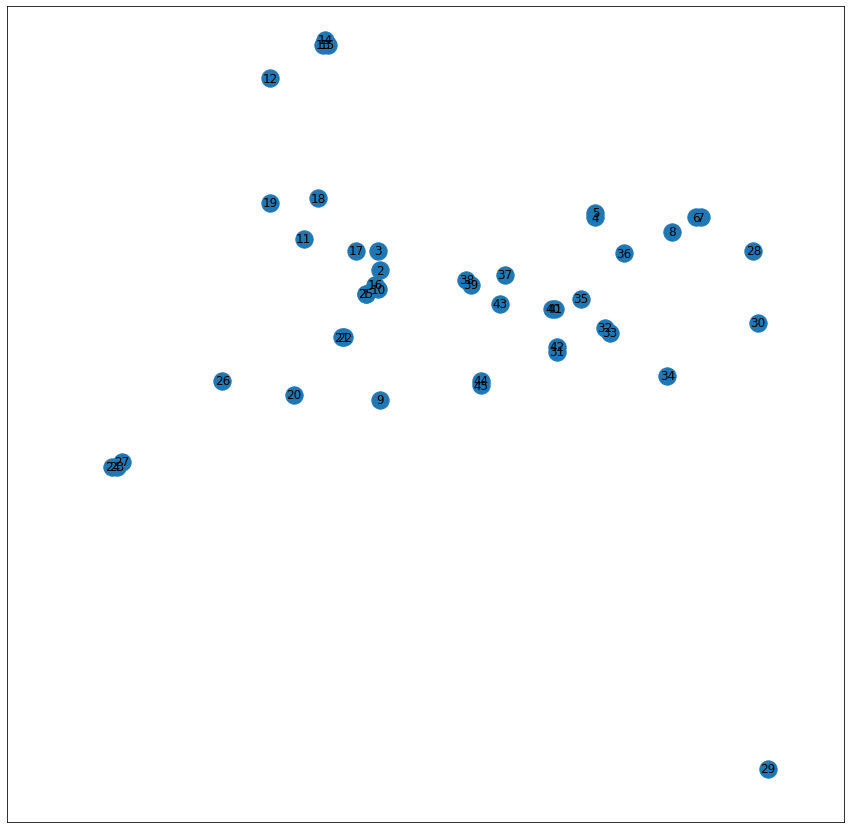

In [87]:
showNodes(manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

Nous pouvons maintenant tester le processus de *recuit simulé* sur ce plus grand exemple.  Le code test est très similaire au code que vous avez commenté à la question (5) ci-haut.  Regarder l'étape supplémentaire, *plot_learning*, qui montre la valeur de la fonction de coût au fur et à mesure de la progression de l'algorithme. 

Solution ['10', '16', '25', '1', '2', '3', '17', '11', '18', '19', '12', '13', '15', '14', '38', '39', '43', '37', '40', '41', '35', '32', '33', '42', '31', '44', '45', '9', '22', '21', '20', '26', '27', '23', '24', '4', '5', '36', '8', '6', '7', '28', '30', '34', '29'] takes a total of 595.39


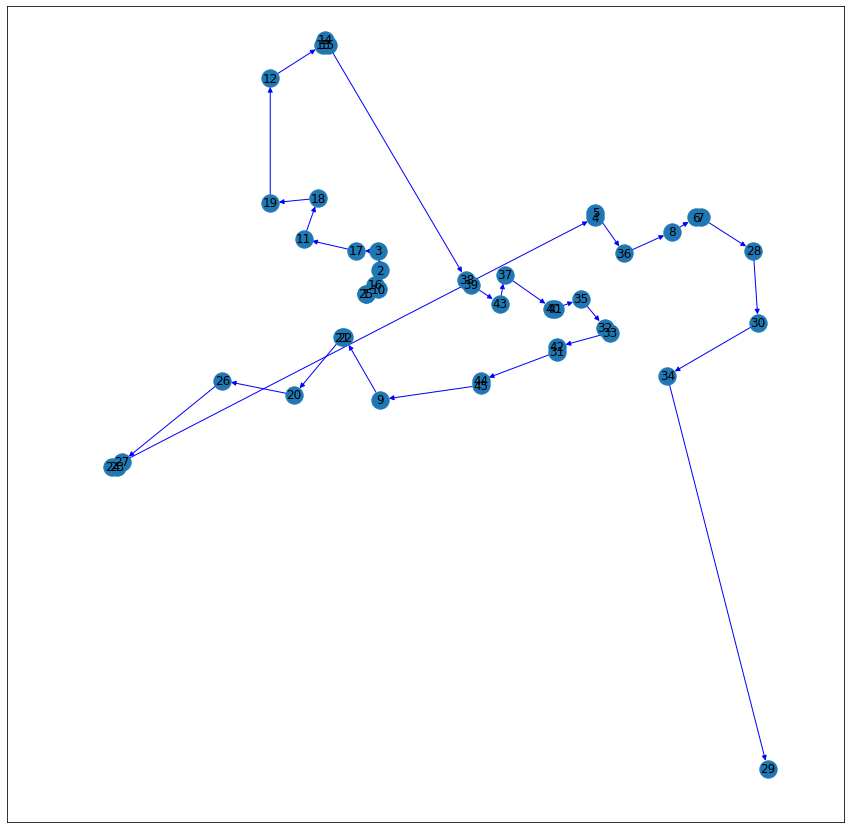

6.708203932499369
1e-08
Best fitness obtained:  493.458
Improvement over greedy heuristic:  0.2216


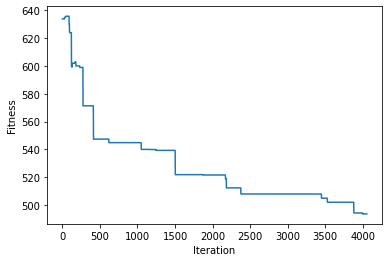

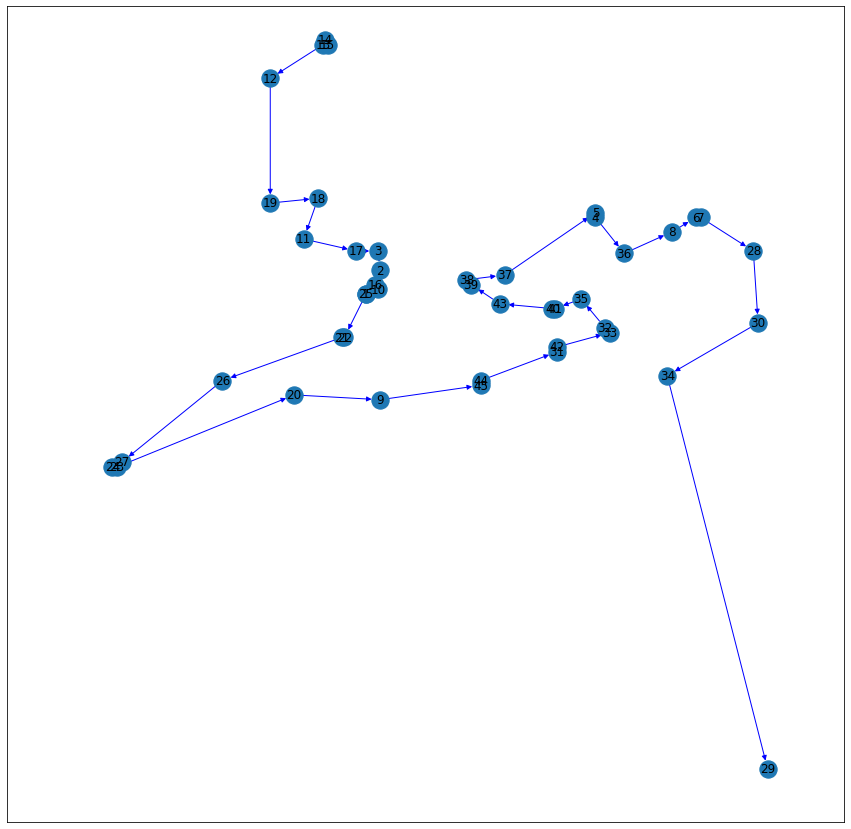

The 3 closest nodes are ['16', '3', '10']
The normalized distances are [0.448303482183377, 0.2758482589083115, 0.2758482589083115]
The closest node is 16 with a probability of 0.448303482183377
The 3 closest nodes are ['10', '25', '1']
The normalized distances are [0.7614105084940352, 0.11959039522652605, 0.11899909627943875]
The closest node is 10 with a probability of 0.7614105084940352
The 3 closest nodes are ['25', '1', '3']
The normalized distances are [0.47393105341577146, 0.4725242087641421, 0.05354473782008657]
The closest node is 25 with a probability of 0.47393105341577146
The 3 closest nodes are ['1', '17', '3']
The normalized distances are [0.9999976725617995, 1.178907495112591e-06, 1.1485307054389632e-06]
The closest node is 1 with a probability of 0.9999976725617995
The 3 closest nodes are ['17', '3', '22']
The normalized distances are [0.35537856851069033, 0.34623130415095826, 0.29839012733835135]
The closest node is 17 with a probability of 0.35537856851069033
The 3 clo

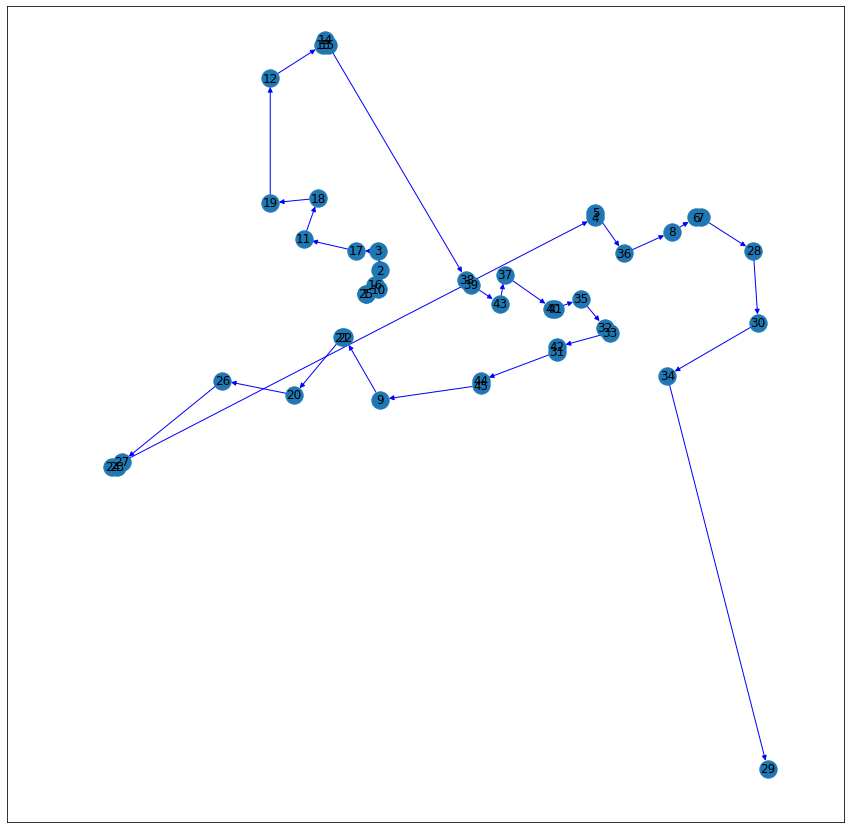

The 4 closest nodes are ['41', '40', '32', '33']
The normalized distances are [0.3545691214487914, 0.30352081974721434, 0.19907076181099537, 0.14283929699299894]
The closest node is 32 with a probability of 0.19907076181099537
The 4 closest nodes are ['33', '42', '31', '41']
The normalized distances are [0.9532248223117038, 0.016430953074116874, 0.01524791824807533, 0.015096306366103748]
The closest node is 33 with a probability of 0.9532248223117038
The 4 closest nodes are ['42', '31', '41', '40']
The normalized distances are [0.282095597705105, 0.2676797672629793, 0.23321866718935255, 0.2170059678425632]
The closest node is 42 with a probability of 0.282095597705105
The 4 closest nodes are ['31', '41', '40', '43']
The normalized distances are [0.9658170957578206, 0.01503070916173237, 0.014859674654856712, 0.004292520425590313]
The closest node is 31 with a probability of 0.9658170957578206
The 4 closest nodes are ['41', '40', '43', '44']
The normalized distances are [0.38428312522722

Best fitness obtained:  531.878
Improvement over randomized greedy heuristic:  0.2382


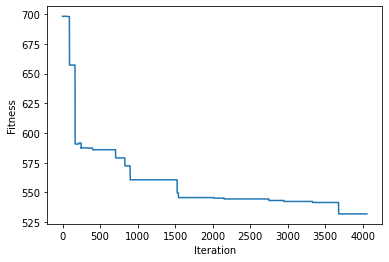

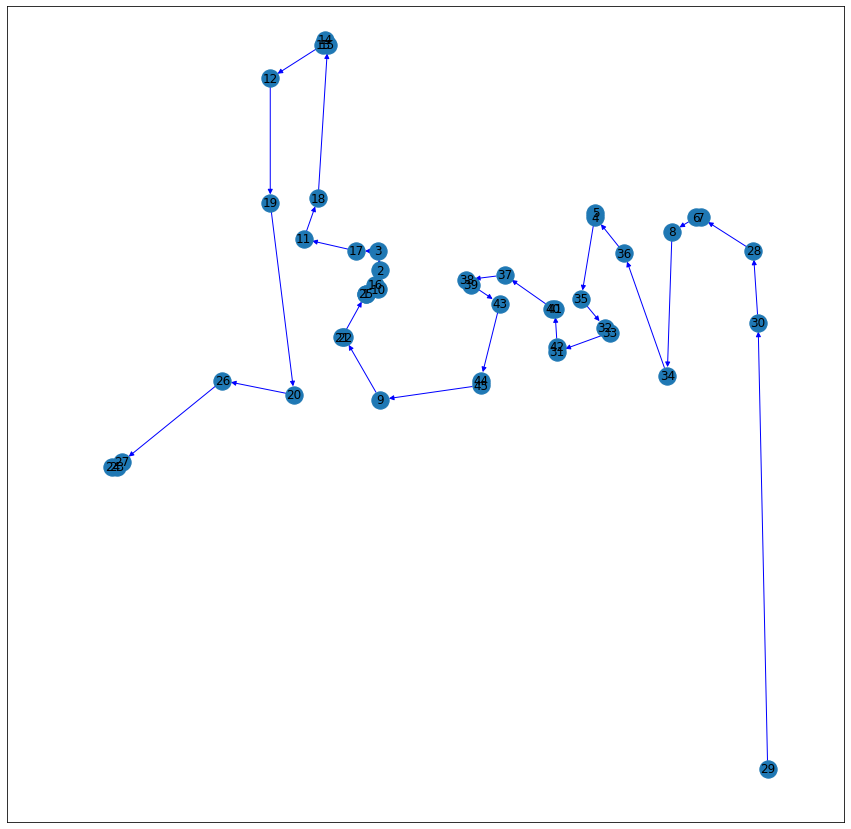

In [124]:
firstSol = greedy_solution(manyCities)
distances = distDict(manyCities)
print('Solution {} takes a total of {}'.format(firstSol,totalDist(firstSol, distances)))
showPath(firstSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

sa = SimAnneal(manyCities, False)
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

secondSol = randomized_greedy_solution(manyCities, 3)
print('Solution {} takes a total of {}'.format(secondSol,totalDist(secondSol, distances)))
showPath(firstSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

sa2 = SimAnneal(manyCities, True, 4)
betterSol2 = sa2.anneal()
sa2.plot_learning()
showPath(betterSol2, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

**(TO DO) Q6 - 2 points**  
Tester le recuit simulé en variant certains paramètres, tel en faisant un changement sur les températures à explorer (T, stopping_T, alpha), ou encore sur le nombre d'itérations maximales à faire.  Ces paramètres sont tous des paramètres possibles à assigner à l'instantiation de la classe SimAnneal. Explorer 4 variations ci-bas.

Test1
1000
1e-08
Best fitness obtained:  504.354
Improvement over greedy heuristic:  0.1556


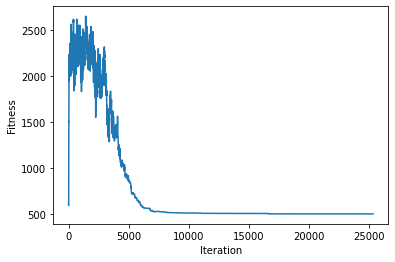

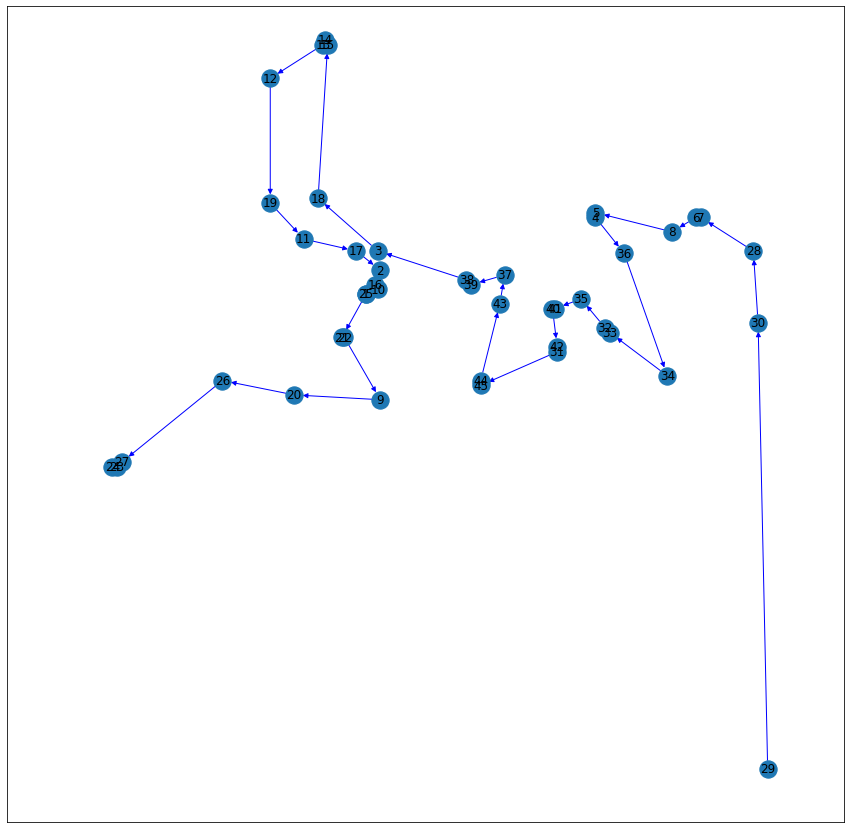

Test2
The 4 closest nodes are ['4', '36', '8', '35']
The normalized distances are [0.9843312082489634, 0.009093698844359569, 0.003619050159308762, 0.002956042747368287]
The closest node is 36 with a probability of 0.009093698844359569
The 4 closest nodes are ['4', '8', '35', '32']
The normalized distances are [0.37510238159545906, 0.28777169635390043, 0.20208344089386204, 0.13504248115677847]
The closest node is 4 with a probability of 0.37510238159545906
The 4 closest nodes are ['8', '35', '41', '6']
The normalized distances are [0.3223916011515743, 0.2866860919380827, 0.1971906574896866, 0.1937316494206565]
The closest node is 8 with a probability of 0.3223916011515743
The 4 closest nodes are ['6', '7', '28', '35']
The normalized distances are [0.5186356405245673, 0.39188833197568684, 0.057817724517717474, 0.03165830298202846]
The closest node is 7 with a probability of 0.39188833197568684
The 4 closest nodes are ['6', '28', '30', '35']
The normalized distances are [0.991503618081235

Best fitness obtained:  514.251
Improvement over randomized greedy heuristic:  0.2316


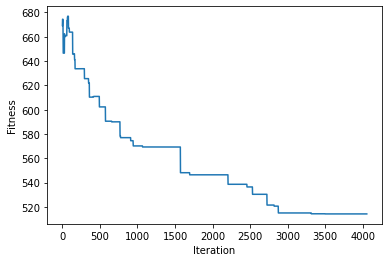

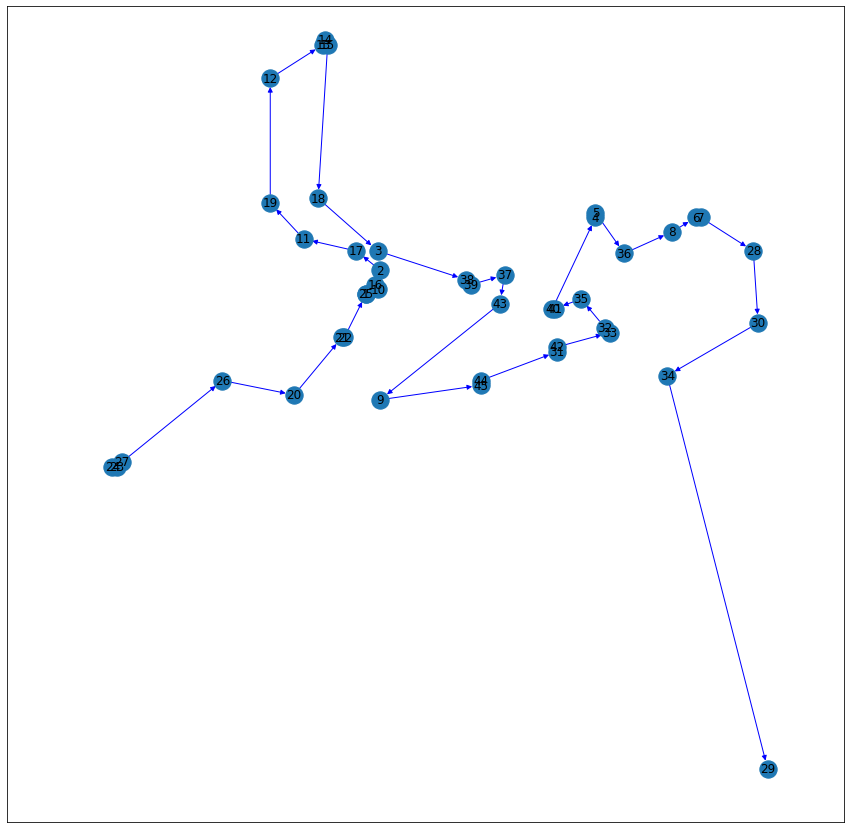

Test3
1000
1e-08
Best fitness obtained:  623.361
Improvement over greedy heuristic:  0.0


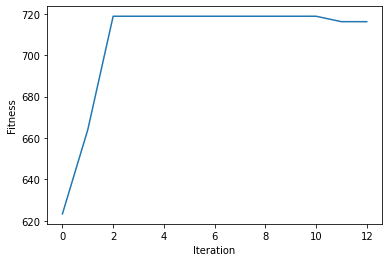

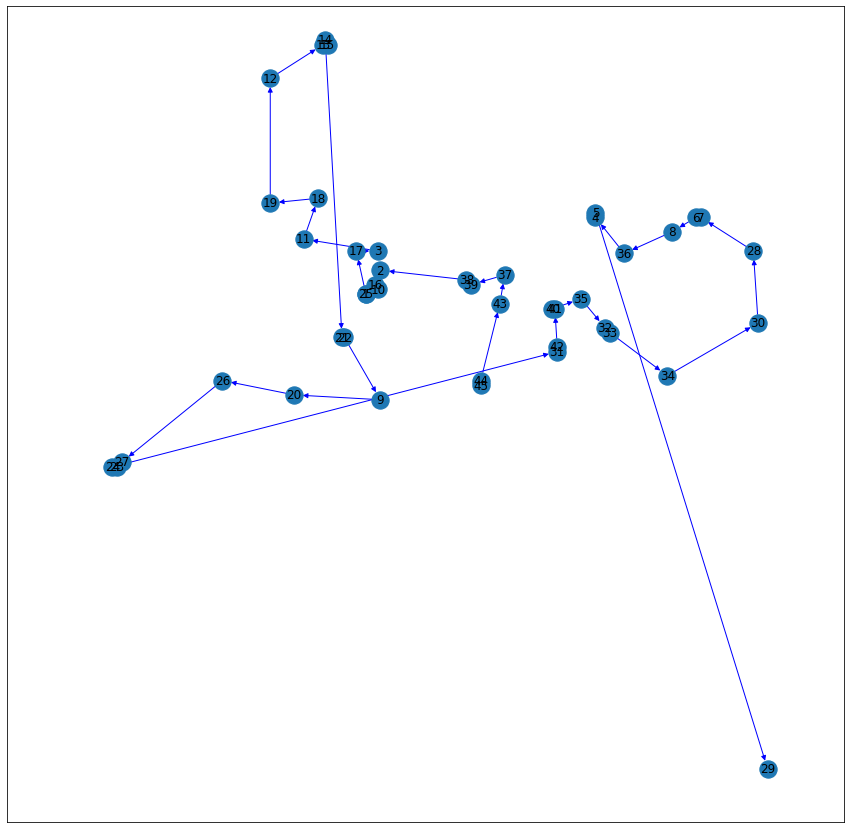

Test4
The 4 closest nodes are ['5', '36', '8', '35']
The normalized distances are [0.9823486861740709, 0.01064807080268276, 0.003706894468692375, 0.0032963485545539095]
The closest node is 5 with a probability of 0.9823486861740709
The 4 closest nodes are ['36', '8', '35', '6']
The normalized distances are [0.5081487389308527, 0.20222967640069928, 0.16518134369850856, 0.12444024096993966]
The closest node is 36 with a probability of 0.5081487389308527
The 4 closest nodes are ['8', '35', '32', '6']
The normalized distances are [0.38475647499200083, 0.27018957513096253, 0.1805544801048032, 0.1644994697722334]
The closest node is 6 with a probability of 0.1644994697722334
The 4 closest nodes are ['7', '8', '28', '30']
The normalized distances are [0.9651351349517865, 0.028385859131906277, 0.005001019831774255, 0.0014779860845329648]
The closest node is 7 with a probability of 0.9651351349517865
The 4 closest nodes are ['8', '28', '30', '35']
The normalized distances are [0.721714184007297

Best fitness obtained:  547.327
Improvement over randomized greedy heuristic:  0.2786


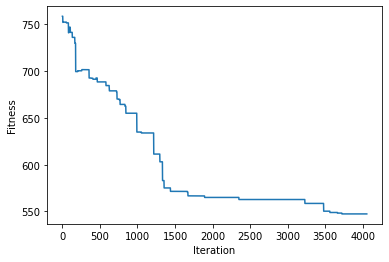

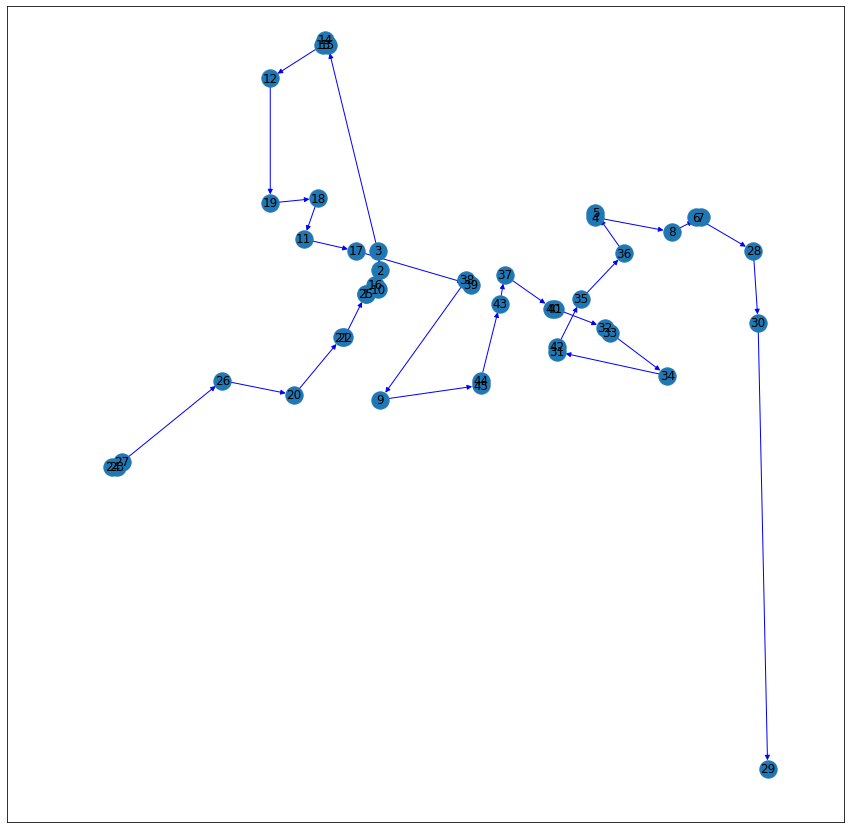

In [128]:
# (TO DO) Look at this line from the SimAnneal class above
# def __init__(self, nodes, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
# This means that parameters T, alpha, stopping_T and stopping_iter all have defaults, but could be changed
# For example, calling SimAnneal(manyCities, stopping_iter=100) means that I set a maximum of 100 iterations.
# Try a few variations and look at the differences

# Test 1 ... (Use a Greedy solution, see comment above) ...
print("Test1")
sa = SimAnneal(manyCities, False)
sa.T = 1000
sa.alpha = 0.999
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 2 ... (Use a Randomized Greedy solution, see comment above)...
print("Test2")
sa = SimAnneal(manyCities, True)
betterSol = sa.anneal()
sa.stopping_iter = 100
sa.alpha = 0.5
sa.T = 100
sa.stopping_T = 1
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

# Test 3 ... (Use a Greedy solution, see comment above)...
print("Test3")
sa = SimAnneal(manyCities, False)
sa.T = 1000
sa.stopping_T = 0.01
sa.alpha = 0.1
betterSol = sa.anneal()
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])

               
# Test 4 (Use a Randomized Greedy solution, see comment above)...
print("Test4")
sa = SimAnneal(manyCities, True)
betterSol = sa.anneal()
sa.stopping_iter = 1000000000
sa.alpha = 0.999999
sa.plot_learning()
showPath(betterSol, manyCities, size=(15,15), xLim=[-75,100], yLim=[-110,60])


#### Signature

Je, -------Bhavika Sewpal-------------, déclare que les réponses inscrites dans ce notebook sont les miennes.